In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

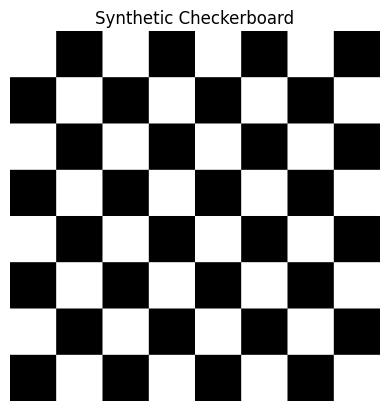

In [3]:
# 合成チェッカーボード画像を生成する
def generate_checkerboard(tile_size=40, num_tiles=8):
    checkerboard = np.kron([[1, 0] * (num_tiles//2), [0, 1] * (num_tiles//2)] * (num_tiles//2), np.ones((tile_size, tile_size)))
    checkerboard = (checkerboard * 255).astype(np.uint8)
    return checkerboard

img = generate_checkerboard()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Synthetic Checkerboard")
plt.show()

In [4]:
# 画像のコーナーを検出するためのHarrisコーナー検出器
# 引数:
# - image: 入力画像（グレースケールまたはBGR）
# - k: Harrisコーナー検出器の感度パラメータ
# - window_size: ガウシアンフィルターのウィンドウサイズ
# - threshold: コーナー応答の閾値
# 戻り値:
# - result: コーナーを赤色でマークした画像
# - R: コーナー応答のマトリックス
# 参考文献:
# - https://docs.opencv.org/4.x/da/d6a/tutorial_py_harris.html
# - https://docs.opencv.org/4.x/db/d25/tutorial_py_corner_harris.html
def harris_corner_detector(image, k=0.04, window_size=3, threshold=0.01):
    # 必要に応じて画像をfloat32とグレースケールに変換する。
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    gray = np.float32(gray)

    # 勾配を計算する
    Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    # 偏微分の積を計算する
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    # Aガウシアンフィルターをかける（平滑化）
    Ix2 = cv2.GaussianBlur(Ix2, (window_size, window_size), sigmaX=1)
    Iy2 = cv2.GaussianBlur(Iy2, (window_size, window_size), sigmaX=1)
    Ixy = cv2.GaussianBlur(Ixy, (window_size, window_size), sigmaX=1)

    # ハリスのコーナー応答を計算する
    det_M = Ix2 * Iy2 - Ixy ** 2
    trace_M = Ix2 + Iy2
    R = det_M - k * (trace_M ** 2)

    # 閾値処理
    R_max = R.max()
    corner_response = R > threshold * R_max

    # 視覚化するために結果を画像として返す
    # ここでは、コーナー応答を赤色でマークする
    result = cv2.cvtColor(gray.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    result[corner_response] = [0, 0, 255]  # mark corners in red

    return result, R

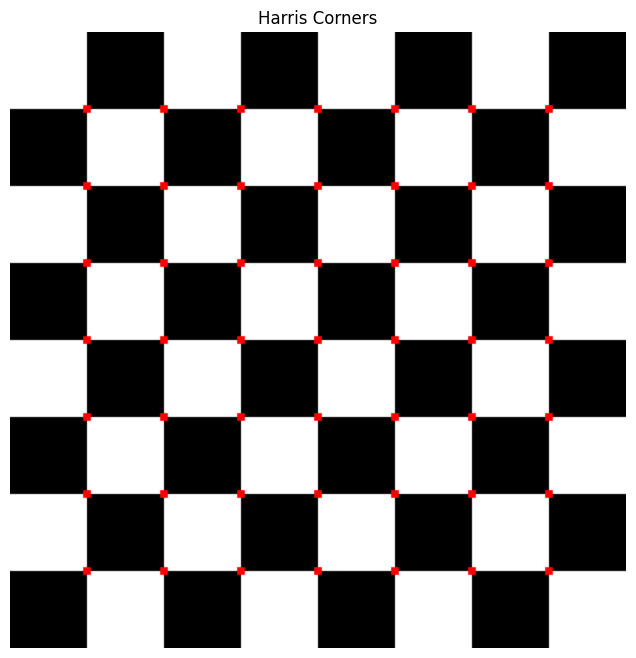

In [5]:
# Run Harris corner detector
corner_img, R = harris_corner_detector(img)

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))
plt.title("Harris Corners")
plt.axis('off')
plt.show()

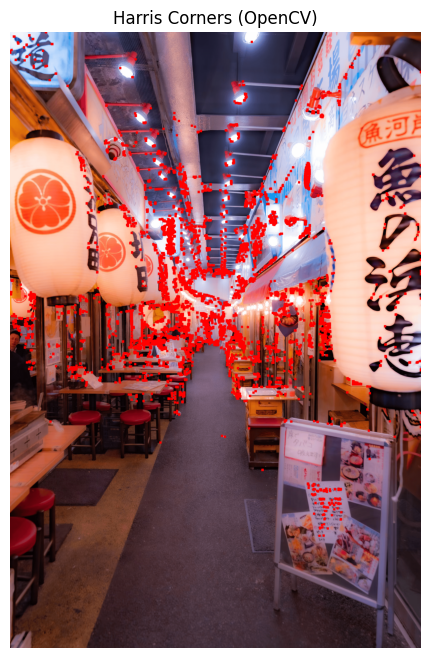

In [6]:
# unsplash.pngを読んで白黒画像に変換
img_color = cv2.imread('unsplash.png')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# OpenCV の cornerHarris を使う
dst = cv2.cornerHarris(src=img_gray, blockSize=2, ksize=3, k=0.04)

# 結果を膨張させて見やすくする（コーナー部分を強調）
dst_dilated = cv2.dilate(dst, iterations=5, kernel=None)

# しきい値を超える箇所を赤く塗る（元画像にーナー部分を色付け）
img_color[dst_dilated > 0.01 * dst_dilated.max()] = [0, 0, 255]  # 赤色

# 表示
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Harris Corners (OpenCV)")
plt.axis('off')
plt.show()